# How to use Circuit Operators to learn Sum of Squares Circuits

By the end of this notebook, you will know how to compose **circuit operators** implemend in Cirkit as to represent the _exact_ computation of some quantities of interest in terms of circuits. In order to motivate and show the usage of circuit operators, we build and learn a Sum of Squares (SOS) probabilistic circuit (PC) for distribution estimation, as introduced in the paper [Sum of Squares Circuits](https://arxiv.org/abs/2408.11778). While PCs are typically learned by assuming their parameters and input functions to be non-negative, SOS PCs can be learned with real or complex parameters, which makes them much more expressive models. As such, this notebook also shows how Cirkit allows us you build circuits with real or complex parameters seamlessly.

## Background: From Squared Subtractive Mixture Models to Sum of Squares

Before digging into the code, we provide some background about subtractive and SOS mixtures. Mixture models are typically learned by assuming their parameters and input functions to be non-negative. For this reason, mixture models are restricted to _adding_ probability density, thus requiring a high number of mixture components in order to represent some complex probability distributions. For example, in the following GIF we show a ring-shaped 2D target density (ground truth), and the density learned by Gaussian mixture models (GMMs) with either $K=2$ or $K=16$ components.

<div style="max-width:50%;">

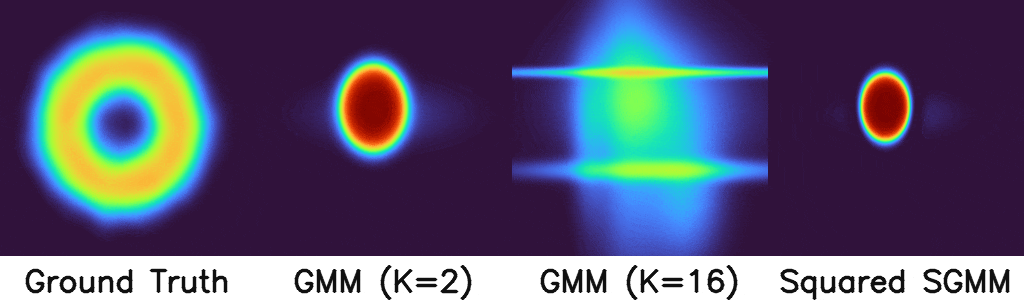

</div>

A GMM with $K=2$ components struggles to represent the ground truth density. However, if we allow the GMM to also _subtract_ probability density by means of negative mixture weights, we can capture such a distribution with just two Gaussian components, where an inner one is subtracted from an outer one. However, if we allow for negative mixture weights, _how can we ensure we are still modelling a non-negative function and therefore a density function?_ To ensure non-negativity, we square a subtractive mixture model. In the GIF above, a squared subtractive Gaussian mixture model (squared SGMM) with two Gaussian components captures the target distribution.

However, a _single_ squared subtractive mixture model might not be enough for more complex distributions. For example, consider a 2D target density consisting of three rings, as showed in the GIF below (ground truth). A GMM with enough components can capture the "holes" of the target distribution, while a single squared SGMM struggles to do the same. The reason is that the squaring operation alone introduces a limitation that makes the model less flexible, which does not occur in the GMM. To overcome this issue, we build a sum of _many_ squared SGMMs, namely a Sum of Squares (SOS) SGMM, that provably surpasses such a limitation and therefore better captures the target distribution with fewer components (i.e., 12 for the GMM while just 6 for the SOS SGMM).

<div style="max-width:50%;">

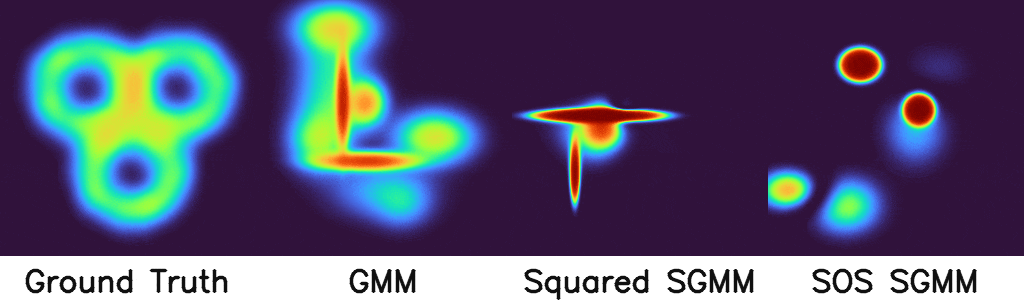

</div>

SOS circuits generalize this idea as to model high-dimensional distributions by _squaring_ and _summing_ deep subtractive mixture models represented as circuits. In the rest of the notebook, we show how the circuit operators implemented in Cirkit allows us to construct and learn an SOS circuit in a few lines of code. In particular, here we learn a simple SOS circuit estimating the distribution of MNIST images and _taking the form of the sum of just two squares_: the real and imaginary part of the output of a circuit with complex parameters.

## Building and Learning SOS PCs: the case of Squared Complex Circuits

To build an SOS circuit encoding the sum of just two squares, we can start from a circuit $c$ with complex parameters computing a complex function, and then square it. Formally, we model a probability distribution $p$ over variables $\mathbf{X}$ as $p(\mathbf{X}) = Z^{-1} |c(\mathbf{X})|^2 = Z^{-1} c(\mathbf{X}) c(\mathbf{X})^\dagger$, where $(\ \cdot\ )^\dagger$ denotes the complex conjugation operation, i.e., $(a+b\mathbf{i})^\dagger = a-b\mathbf{i}$, and $Z$ is the renormalization constant or partition function. Equivalently, we can write $p$ as proportional to the sum of two squares, i.e., $p(\mathbf{X}) \propto \Re(c(\mathbf{X}))^2 + \Im(c(\mathbf{X}))^2$, where $\Re,\Im$ denote real and imaginary part, respectively.

We start by constructing $c$ using the Cirkit library. Since we aim at estimating the distribution of MNIST images, we use the ```cirkit_templates.image_data``` utility, similarly to what we have done in the [learning-a-circuit.ipynb](learning-a-circuit.ipynb) notebook.

In [1]:
from cirkit.templates import circuit_templates
from cirkit.symbolic.circuit import Circuit

def build_symbolic_complex_circuit(region_graph: str) -> Circuit:
    return circuit_templates.image_data(
        (1, 28, 28),                 # The shape of MNIST image, i.e., (num_channels, image_height, image_width)
        region_graph=region_graph,
        # ----------- Input layers hyperparameters ----------- #
        input_layer='embedding',     # Use Embedding maps for the pixel values (0-255) as input layers
        num_input_units=32,          # Each input layer consists of 32 input units that output Embedding entries
        input_params={               # Set how to parameterize the input layers parameters
            # In this case we parameterize the 'weight' parameter of Embedding layers,
            # by choosing them to be complex-valued whose real and imaginary part are sampled uniformly in [0, 1)
            'weight': circuit_templates.Parameterization(dtype='complex', initialization='uniform'),
        },
        # -------- Sum-product layers hyperparameters -------- #
        sum_product_layer='cp-t',    # Use CP-T sum-product layers, i.e., alternate hadamard product layers and dense layersfunction
        num_sum_units=32,            # Each dense sum layer consists of 32 sum units
        # Set how to parameterize the sum layers parameters
        # We paramterize them to be complex-valued whose real and imaginary part are sampled uniformly in [0, 1)
        sum_weight_param=circuit_templates.Parameterization(dtype='complex', initialization='uniform')
    )

In the above, we choose input layers encoding complex embeddings, i.e., each input unit maps a pixel value in $\{0,1,\ldots,255\}$ to the corresponding entry of a vector in $\mathbb{C}^{256}$. In addition, we make use of CP-T as sum-product layers, where sum layers are parameterized with complex weights. For more details about this and other layers, see the [region-graph-and-parameterisations.ipynb](region-graph-and-parameterisations.ipynb) notebook.

## Computing the Partition Function by Composing Circuit Operators

To enable the _exact and efficient_ computation of probabilities, we need to renormalize $p$, i.e., compute the partition function $Z$ exactly. To do so, we use the **circuit operators** in the ```cirkit.symbolic.functional``` module as to automatically construct the symbolic circuit that would compute $Z$. In short, all we need is to _compose the operators_ as to encode the formula $Z = \int_{\mathrm{dom}(\mathbf{X})} |c(\mathbf{x})|^2 \mathrm{d}\mathbf{x}$ as yet another circuit. Namely, we need three circuit operators: ```conjugate```, ```multiply``` and ```integrate```, i.e., we can write in pseudocode ```Z = integrate(multiply(c, conjugate(c)))```.

To ensure tractability, each of these operators has **pre-conditions** on structural properties that the circuit operands must satisfy, and **post-conditions** on the properties and semantics of the output circuit:
- Circuit multiplication ```c' = multiply(c1, c2)```
  - Pre-condition: ```c1``` and ```c2``` are _compatible_, i.e., they share the same partitionings of variables at the products.
  - Post-condtion: ```c'``` is _smooth_ and _decomposable_ and encodes the product of ```c1``` and ```c2```.
- Circuit conjugation ```c' = conjugate(c)```
  - Pre-condition: ```c``` is a circuit with possibly complex parameters.
  - Post-condition: ```c'``` is a circuit of the same structure of ```c``` and computing the complex conjugation of ```c```.
- Circuit integration ```c' = integrate(c)```:
  - Pre-condition: ```c``` is a _smooth_ and _decomposable_ circuit.
  - Post-condition: ```c'``` is a circuit exactly encoding the integral of ```c``` over the whole variables domain.

By matching pre-conditions and post-conditions, we are allowed to compose these operators as to exactly compute math formulae using circuits.

For our purposes and to satisfy the above pre-conditions, we construct a circuit from a region graph that is structured-decomposable. This will yield a circuit that is compatible with itself, which allows us to apply the ```multiply``` operator with itself as to square it. Then, the circuit resulting from the multiply operator is smooth and decomposable, and therefore it satisfies the pre-conditions of the ```integrate``` operator. We build the symbolic circuit below and show its structural properties.

In [2]:
# Build a symbolic complex circuit by overparameterizing a Quad-Tree (4) region graph, which is structured-decomposable
symbolic_circuit = build_symbolic_complex_circuit('quad-tree-4')

# Print which structural properties the circuit satisfies
print(f'Structural properties:')
print(f'  - Smoothness: {symbolic_circuit.is_smooth}')
print(f'  - Decomposability: {symbolic_circuit.is_decomposable}')
print(f'  - Structured-decomposability: {symbolic_circuit.is_structured_decomposable}')

Structural properties:
  - Smoothness: True
  - Decomposability: True
  - Structured-decomposability: True


Next, we compose the circuit operators mentioned above as to construct the symbolic circuit _exactly_ encoding $Z$.

In [3]:
import cirkit.symbolic.functional as SF

# Construct the circuit computing Z, i.e., the integral of |c(X)|^2 over the complete domain of X
symbolic_circuit_partition_func = SF.integrate(
    # Construct the circuit computing |c(X)|^2 = c(X) c(X)^* = Re(c(X))^2 + Im(c(X))^2
    SF.multiply(symbolic_circuit, SF.conjugate(symbolic_circuit))
)

Note that the above just required a single line of code using Cirkit! The only things we needed to care about are the structural properties of the circuits and the pre- and post-conditions of the circuit operators.

## Learning Complex Squared Circuits

The loss we will use to learn our model is the negated log-likelihood (NLL), which can be written as
$$
\mathrm{NLL} := -\sum\nolimits_{\mathbf{x}\in\mathcal{D}} \log p(\mathbf{x}) = \log Z - \sum\nolimits_{\mathbf{x}\in\mathcal{D}} 2 \log |c(\mathbf{x})|,
$$
where $\mathcal{D}$ denotes the training data points.
For this reason, we need to compile two circuits: (i) the circuit $c$ and (ii) the circuit computing the partition function $Z$, and use them both to compute the NLL loss.

We start by importing torch, setting the seed, the device, and by loading the MNIST dataset.

In [4]:
import random
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# Set some seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the torch device to use
device = torch.device('cuda')

# Load the MNIST data set and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    # Flatten the images and set pixel values in the [0-255] range
    transforms.Lambda(lambda x: (255 * x.view(-1)).long())
])
data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

### Compilation Step and Optimization

To compile the circuits, we instantiate a ```PipelineContext``` object and refer the reader to the [compilation-options.ipynb](compilation-options.ipynb) notebook for a tutorial on compiling circuits and on the meaning of the different flags. Here, one important flag is the evaluation semiring. That is, to ensure numerical stability, we evaluate circuits by computing sum and products as they were operations of a semiring where the addition is the LogSumExp and the multiplication is the addition. More specifically, since our complex circuit can have negative real or complex parameter, we choose a generalization of the mentioned semiring over the complex plane.

In [5]:
from cirkit.pipeline import PipelineContext, compile

# Instantiate the pipeline context
ctx = PipelineContext(
    backend='torch',  # Choose PyTorch as compilation backend
    # ---- Use the evaluation semiring (C, +, x), where + is the numerically stable LogSumExp and x is the sum ---- #
    semiring='complex-lse-sum',
    # ------------------------------------------------------------------------------------------------------------- #
    fold=True,     # Fold the circuit to better exploit GPU parallelism
    optimize=True  # Optimize the layers of the circuit
)

with ctx:  # Compile the circuits computing log |c(X)| and log |Z|
    circuit = compile(symbolic_circuit)
    circuit_partition_func = compile(symbolic_circuit_partition_func)

Since we have chosen the ```complex-lse-sum``` semiring, the circuit being compiled will outputs values in the log-space. More precisely, ```circuit``` is the circuit computing $\log |c(\mathbf{x})|$, while ```circuit_partition_func``` is the circuit computing the logarithm of the partition function, i.e., $\log Z$.

Next, we instantiate a PyTorch optimizer, such as Adam. Note that PyTorch automatically supports automatic differentiation over complex tensors.

In [6]:
# Initialize a torch optimizer of your choice,
#  e.g., Adam, by passing the parameters of the circuit
optimizer = optim.Adam(circuit.parameters(), lr=0.01)

In the following training loop, we learn the parameters of the complex squared circuit by minimizing the negative log-likelihood computed on MNIST images.

In [7]:
num_epochs = 15
step_idx = 0
running_loss = 0.0

# Move the circuit to chosen device
circuit = circuit.to(device)

for epoch_idx in range(num_epochs):
    for i, (batch, _) in enumerate(train_dataloader):
        # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
        # so we unsqueeze a dimension for the channel.
        batch = batch.to(device).unsqueeze(dim=1)

        # -------- Computation of the negated log-likelihoods loss -------- #
        # Compute the logarithm of the squared scores of the batch, by evaluating the circuit
        log_scores = circuit(batch)                 # log |c(x)|
        log_squared_scores = 2.0 * log_scores.real  # 2 * log |c(x)|, i.e., equivalent to log |c(x)|^2
        # Compute the log-partition function
        log_partition_func = circuit_partition_func().real  # log Z
        # Compute the log-likelihoods, log p(x) = 2 * log |c(X)| - log Z
        log_likelihoods = log_squared_scores - log_partition_func
        # We take the negated average log-likelihood as loss
        loss = -torch.mean(log_likelihoods)
        # ------------------------------------------------------------------ #

        # Update the parameters of the circuits, as any other model in PyTorch
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.detach() * len(batch)
        step_idx += 1
        if step_idx % 300 == 0:
            print(f"Step {step_idx}: Average NLL: {running_loss / (300 * len(batch)):.3f}")
            running_loss = 0.0

Step 300: Average NLL: 1277.903
Step 600: Average NLL: 759.341
Step 900: Average NLL: 711.138
Step 1200: Average NLL: 683.216
Step 1500: Average NLL: 668.198
Step 1800: Average NLL: 659.092
Step 2100: Average NLL: 653.012
Step 2400: Average NLL: 644.388
Step 2700: Average NLL: 641.965
Step 3000: Average NLL: 640.378
Step 3300: Average NLL: 636.618


Next, we evaluate the model on the test MNIST images, and show the bits-per-dimension metric.

In [8]:
with torch.no_grad():
    # -------- Compute the log-partition function -------- #
    # Note that we need to do it just one, since we are not updating the parameters here
    log_partition_func = circuit_partition_func().real
    # ---------------------------------------------------- #

    test_lls = 0.0
    for batch, _ in test_dataloader:
        batch = batch.to(device).unsqueeze(dim=1)

        # -------- Compute the log-likelihoods of hte unseen samples -------- #
        # Compute the logarithm of the squared scores of the batch, by evaluating the circuit
        log_scores = circuit(batch)
        log_squared_scores = 2.0 * log_scores.real
        # Compute the log-likelihoods
        log_likelihoods = log_squared_scores - log_partition_func
        # ------------------------------------------------------------------- #

        test_lls += log_likelihoods.sum().item()

    # Compute average test log-likelihood and bits per dimension
    average_ll = test_lls / len(data_test)
    bpd = -average_ll / (28 * 28 * np.log(2.0))
    print(f"Average test LL: {average_ll:.3f}")
    print(f"Bits per dimension: {bpd:.3f}")

Average test LL: -680.237
Bits per dimension: 1.252


## Conclusion and Further Reading

1. **Circuit operators** can be composed together as to represent the exact computation of complicated math formulae in terms of symbolic circuits. The library support many other circuit operators: see the documentation of the module ```cirkit.symbolic.functional``` for more.
2. We can seamlessly build and learn **circuits with real and complex parameters**, such as the SOS PCs and squared complex circuits in this notebook. Allowing real/complex parameters in PCs is crucial to increase their expressiveness, as noted in [Sum of Squares Circuits](https://arxiv.org/abs/2408.11778) and [Subtractive Mixture Models via Squaring: Representation and Learning](https://openreview.net/forum?id=xIHi5nxu9P).
3. The **easy integration with PyTorch** allows you to abstract away from all the implementation details of the circuit operators and the chosen parameterization.